In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import argparse

from argparse import Namespace

print(torch.device(),torch.cuda.is_available())

/home/jrobador/anaconda3/envs/INRIA/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def parse_option():
    defaults = {
    'print_freq': 10,
    'save_freq': 50,
    'batch_size': 32,
    'num_workers': 1,
    'epochs': 1000,
    'learning_rate': 0.05,
    'lr_decay_epochs': '700',
    'lr_decay_rate': 0.1,
    'weight_decay': 1e-4,
    'momentum': 0.9,
    'model': 'resnet50',
    'dataset': 'cifar10',
    'mean': None,
    'std': None,
    'data_folder': "./",
    'tb_folder': "./",
    'size': 32,
    'method': 'SupCon',
    'temp': 0.07,
    'cosine': False,
    'warm': False,
    'trial': '0',
}

    args = Namespace(**defaults)

    return args

opt = parse_option()



In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

model_dict = {
    'resnet50': [resnet50, 2048]
    }

class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat


In [4]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]
    
def set_loader(opt):
    # construct data loader
    if opt.dataset == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif opt.dataset == 'cifar100':
        mean = (0.5071, 0.4867, 0.4408)
        std = (0.2675, 0.2565, 0.2761)
    elif opt.dataset == 'path':
        mean = eval(opt.mean)
        std = eval(opt.std)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=opt.size, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    if opt.dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=opt.data_folder,
                                         transform=TwoCropTransform(train_transform),
                                         download=True)
    elif opt.dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root=opt.data_folder,
                                          transform=TwoCropTransform(train_transform),
                                          download=True)
    elif opt.dataset == 'path':
        train_dataset = datasets.ImageFolder(root=opt.data_folder,
                                            transform=TwoCropTransform(train_transform))
    else:
        raise ValueError(opt.dataset)

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
        num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)
    
    return train_loader

train_loader = set_loader(opt)


Files already downloaded and verified


In [5]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


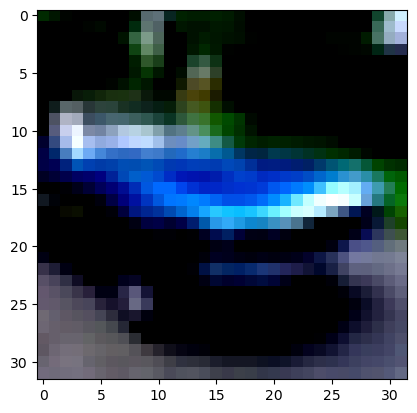

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class = car
(3, 32, 32)


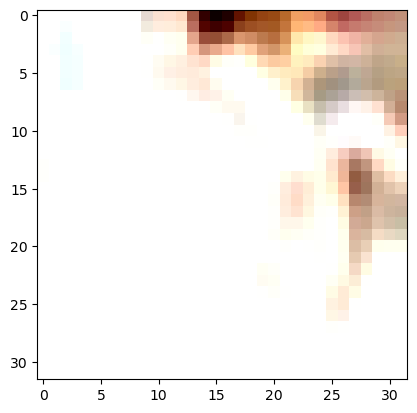

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class = frog
(3, 32, 32)


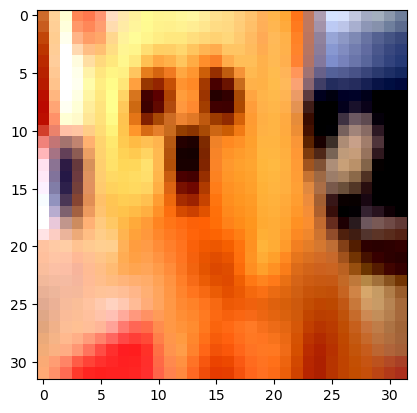

class = dog
breaking


In [6]:
import torchvision

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.show()

for idx, (images, labels) in enumerate(train_loader):
    imshow(images[0][idx])
    print (f'class = {classes[labels[idx].item()]}')
    if idx > 1:
        print("breaking")
        break
    


In [7]:
for idx, (images, labels) in enumerate(train_loader):
    if idx == 0:
        print (labels.shape[0], labels)
        mask = torch.eq(labels, labels.T).float()
        print (mask.shape, mask)


32 tensor([3, 6, 1, 6, 5, 4, 4, 5, 1, 1, 9, 4, 0, 0, 0, 9, 3, 1, 4, 9, 5, 3, 0, 3,
        4, 4, 7, 1, 8, 6, 1, 2])
torch.Size([32]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


/tmp/ipykernel_245285/2891093952.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  mask = torch.eq(labels, labels.T).float()


In [8]:
import torch.optim as optim

model = SupConResNet()
criterion = SupConLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=opt.learning_rate,
                      momentum=opt.momentum,
                      weight_decay=opt.weight_decay)

In [10]:
import sys
from util import AverageMeter, warmup_learning_rate, adjust_learning_rate
import time


def train(train_loader, model, criterion, optimizer, epoch, opt):
    """one epoch training"""
    model.train()
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    data_time = AverageMeter()
    end = time.time()
    
    for idx, (images, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        bsz = labels.shape[0]

        # warm-up learning rate
        warmup_learning_rate(opt, epoch, idx, len(train_loader), optimizer)

        # compute loss
        features = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if opt.method == 'SupCon':
            loss = criterion(features, labels)
        elif opt.method == 'SimCLR':
            loss = criterion(features)
        else:
            raise ValueError('contrastive method not supported: {}'.
                             format(opt.method))


        losses.update(loss.item(), bsz)
        
        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % opt.print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))
            sys.stdout.flush()

    return losses.avg




In [83]:
import os
import tensorboard_logger as tb_logger

logger = tb_logger.Logger(logdir=opt.tb_folder, flush_secs=2)

# iterations = opt.lr_decay_epochs.split(',')
opt.lr_decay_epochs = list([])
for it in iterations:
    opt.lr_decay_epochs.append(int(it))


for epoch in range(1, opt.epochs + 1):
    adjust_learning_rate(opt, optimizer, epoch)
    # train for one epoch
    time1 = time.time()
    loss = train(train_loader, model, criterion, optimizer, epoch, opt)
    time2 = time.time()
    print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))
    # tensorboard logger
    logger.log_value('loss', loss, epoch)
    logger.log_value('learning_rate', optimizer.param_groups[0]['lr'], epoch)
    if epoch % opt.save_freq == 0:
        save_file = os.path.join(
            opt.save_folder, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
        save_model(model, optimizer, opt, epoch, save_file)
# save the last model
save_file = os.path.join(
    opt.save_folder, 'last.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

Train: [1][10/1563]	BT 5.064 (5.490)	DT 0.002 (0.019)	loss 4.143 (4.143)
Train: [1][20/1563]	BT 5.886 (5.633)	DT 0.003 (0.010)	loss 4.143 (4.143)
Train: [1][30/1563]	BT 7.187 (6.112)	DT 0.007 (0.008)	loss 4.143 (4.143)
Train: [1][40/1563]	BT 7.927 (6.242)	DT 0.002 (0.007)	loss 4.143 (4.143)
Train: [1][50/1563]	BT 6.459 (6.281)	DT 0.003 (0.006)	loss 4.143 (4.143)
Train: [1][60/1563]	BT 6.470 (6.267)	DT 0.004 (0.005)	loss 4.143 (4.143)
Train: [1][70/1563]	BT 5.805 (6.269)	DT 0.002 (0.005)	loss 4.143 (4.143)
Train: [1][80/1563]	BT 5.755 (6.214)	DT 0.001 (0.004)	loss 4.143 (4.143)
Train: [1][90/1563]	BT 5.774 (6.171)	DT 0.002 (0.004)	loss 4.142 (4.143)
Train: [1][100/1563]	BT 5.732 (6.185)	DT 0.003 (0.004)	loss 4.143 (4.143)
Train: [1][110/1563]	BT 7.225 (6.366)	DT 0.001 (0.004)	loss 4.144 (4.143)
Train: [1][120/1563]	BT 7.414 (6.485)	DT 0.004 (0.004)	loss 4.141 (4.143)
Train: [1][130/1563]	BT 8.649 (6.638)	DT 0.002 (0.004)	loss 4.146 (4.143)
Train: [1][140/1563]	BT 9.369 (6.739)	DT 0.002 